In [1]:
# load and show an image with Pillow
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
import matplotlib.patches as mpatches
from numpy import asarray
import numpy
import cv2 as cv
from numpy.lib.stride_tricks import sliding_window_view
import math
from scipy import signal
# from einops import repeat, rearrange, reduce

In [2]:
numpy.__version__

'1.20.3'

In [3]:
info = {
      "rotation": 245.87732027142948,
      "size": "one-size",
      "color": "yellow",
      "3d_coords": [
        -2.104611396789551,
        -0.7942865490913391,
        0.5
      ],
      "material": "rubber",
      "child": {
        "rotation": 25.89978442503845,
        "size": "one-size",
        "color": "gray",
        "3d_coords": [
          -1.6461938619613647,
          -0.8790992498397827,
          1.5099999904632568
        ],
        "material": "rubber",
        "child": None,
        "shape": "thin_rectangle_01",
        "used": True,
        "obj_name_out": "thin_rectangle_01_0",
        "pixel_coords": [
          119,
          84,
          15.356139183044434
        ],
        "shape_num": 40
      },
      "shape": "cube_container_01",
      "used": True,
      "obj_name_out": "cube_container_01_0",
      "pixel_coords": [
        115,
        102,
        16.124099731445312
      ],
      "shape_num": 7
    }

In [4]:
def image2nptemplate(object_image, parent):
    object_np = asarray(object_image)
    print(object_np.shape)
    
    if parent:
        object_np = numpy.where(object_np < 100, 0, object_np)
        object_np = numpy.where((object_np >= 100) & (object_np < 230), 120, object_np)
        object_np = numpy.where(object_np >= 230, 255, object_np)
    else:
        object_np = numpy.where(object_np <= 250, 0, object_np)
        object_np = numpy.where(object_np > 250, 255, object_np)

    u_values = numpy.unique(object_np)
    print(u_values)
    if 120 in u_values:
        print("Object is container")
        object_np = numpy.where(object_np == 120, 1, 0)
        return object_np
    else:
        print("Object is not a container")
        object_np = numpy.where(object_np == 255, 1, 0)
        return object_np

In [174]:
def create_parent_image_sup(ori_parent_img, obj_in_img, dx, dy, theta, scale=234.4):
    # ori_parent_img: original top view from the template
    # obj_in_img: the object to be placed into the parent to create the image
    # dx: in 3D
    # dy: in 3D
    # theta: in 3D
    # scale: 3Dtopixel scale default 1.8m = 211 pixels -> 1m = 211/1.8 or 117.2
    ori_parent_img_clone = ori_parent_img.copy()
    obj_in_img_clone = obj_in_img.copy()
    di = - dx * scale
    dj = - dy * scale


    # Rotate obj_in_img to theta
    rot_obj_in_img_clone = rotate_image(obj_in_img_clone, theta)
    pyplot.imshow(obj_in_img_clone)
    pyplot.show()
    pyplot.imshow(rot_obj_in_img_clone)
    pyplot.show()

    # Overlay on top of the ori_parent_img_clone and move it to di and dj
    (row_p, col_p, d_p) = ori_parent_img_clone.shape
    (row_c, col_c, d_p) = rot_obj_in_img_clone.shape
    pix_i_left_top = int(col_p*0.5 - col_c*0.5 + di)
    pix_j_left_top = int(row_p*0.5 - row_c*0.5 + dj)

    print(col_p, row_p)
    print(col_c, row_c)
    print(pix_i_left_top, pix_j_left_top)
    for c in range(col_c):
        for r in range(row_c):
            k = rot_obj_in_img_clone[r, c]
            if k[0] > 0:
                ori_parent_img_clone[pix_j_left_top+r, pix_i_left_top+c] = 99

    pyplot.imshow(ori_parent_img_clone)
    pyplot.show()
    cv.imwrite('../sample_overlayed_parent.png', ori_parent_img_clone)
    return ori_parent_img_clone

In [175]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """
    
    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat





[120 255]
(247, 247, 3)
[  0  24  32 110 135 207 215 255]


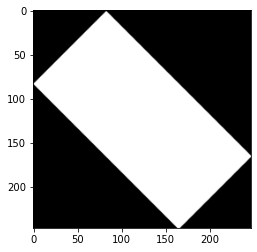

In [176]:
parent_image = cv.imread('../top_view_images/cube_container_01.png')
child_image = cv.imread('../top_view_images/thin_rectangle_01_bottom.png')
print(numpy.unique(asarray(parent_image)))

# rotated_parent = rotate_image(parent_image, -60)
# print(rotated_parent.shape)
# print(numpy.unique(asarray(rotated_parent)))
# pyplot.imshow(rotated_parent)

rotated_child = rotate_image(child_image, 135)
print(rotated_child.shape)
print(numpy.unique(asarray(rotated_child)))
pyplot.imshow(rotated_child)

In [177]:
def image2nptemplate_support(object_image):
    object_np = asarray(object_image)
    print(object_np.shape)

    object_np = numpy.where(object_np < 100, 0, object_np)
    object_np = numpy.where((object_np >= 100) & (object_np < 230), 120, object_np)
    object_np = numpy.where(object_np >= 230, 255, object_np)

    u_values = numpy.unique(object_np[:, :, 1])
    print(u_values)
    if 120 in u_values:
        print("Object is container")
        object_np = numpy.where(object_np == 255, 1, 0)
        return object_np
    else:
        print("Object is not a container")
        object_np = numpy.where(object_np == 255, 1, 0)
        return object_np

def check_support(parent_image, child_image):
    #Image to np template so that
    # Parent's top surface points intersecting
    # with child's bottom surface is computed

    parent_np = image2nptemplate_support(parent_image)
    child_np = image2nptemplate_support(child_image)

    mod_parent_image = Image.fromarray((parent_np*255).astype(numpy.uint8))
    pyplot.imshow(mod_parent_image)
    pyplot.show()
    mod_child_image = Image.fromarray((child_np*255).astype(numpy.uint8))
    pyplot.imshow(mod_child_image)
    pyplot.show()

    parent_np = parent_np[:, :, 0]
    child_np = child_np[:, :, 0]
    print("Unique parent_np:", numpy.unique(parent_np))
    print("Unique child_np:",numpy.unique(child_np))

    v = sliding_window_view(parent_np, child_np.shape)
    print("V shape: ", v.shape)
    print("Parent shape: ", parent_np.shape)
    print("Child shape: ", child_np.shape)

    child_np_tile = numpy.broadcast_to(child_np, (v.shape[0], v.shape[1], child_np.shape[0], child_np.shape[1]))
    print("child_np_tile shape: ", child_np_tile.shape)

    #Reshape
    v = numpy.reshape(v, (v.shape[0], v.shape[1], v.shape[2]*v.shape[3]))
    child_np_tile = numpy.reshape(child_np_tile, (child_np_tile.shape[0], child_np_tile.shape[1], child_np_tile.shape[2]*child_np_tile.shape[3]))

    # Find the intersection at every sliding window
    v_out = ((v == 1) and (child_np_tile ==1))

    # TODO In each sliding window check to see if the CoM or the center of the template
    # is inside a triangle formed by any 3 points from the region of intersection
    # Do this sequentially for every sliding window until the answer is true

In [178]:
def can_sup(parent, child):
    parent_np = asarray(parent)
    child_np = asarray(child)
#     parent_np = numpy.where(parent_np < 100, 0, parent_np)
#     parent_np = numpy.where((parent_np >= 100) & (parent_np < 230), 120, parent_np)
#     parent_np = numpy.where(parent_np >= 230, 255, parent_np)
    row_c, col_c, _ = child_np.shape
#     for i in range(parent_np.shape[0]):
#         for j in range(parent_np.shape[1]):
#             if parent_np[i][j][0] == 255:
                
#                 pix_i_left_top = int(i-row_c*0.5)
#                 pix_j_left_top = int(j-col_c*0.5)

# #                 print(col_c, row_c)
# #                 print(pix_i_left_top, pix_j_left_top)
                
#                 checker = True
#                 for c in range(col_c):
#                     for r in range(row_c):
#                         if pix_i_left_top+r < 0 or pix_j_left_top+c < 0: continue
#                         if parent_np[pix_i_left_top+r, pix_j_left_top+c, 0] == 99 and child_np[r, c, 0] != 0:
#                             checker = False
#                             break
#                     if not checker:
#                         break
                
#                 if checker:
#                     temp_np = combined.copy()
#                     for c in range(col_c):
#                         for r in range(row_c):
#                             if child_np[r,c,0] != 0 and pix_i_left_top+r >= 0 and pix_j_left_top+c >= 0:
#                                 temp_np[pix_i_left_top+r, pix_j_left_top+c, :] = child_np[r, c, 0]
                            
#                     pyplot.imshow(temp_np)
#                     print(str(i) + ", " + str(j))
#                     return True
                
    parent_np = parent_np[:,:,0]
    mod_np = numpy.where(parent_np==99, 1, 0)
    child_np = child_np[:,:,0]
#     %timeit conv = signal.convolve2d(parent_np, child_np, mode='same')
    conv = signal.fftconvolve(mod_np, child_np, mode='same')
    # print(parent_np)
    # print(child_np)
#     print(conv)
    print(conv.shape)
    candidate = numpy.argwhere(conv==0)
    for pos in candidate:
        if pos[0] + col_c//2 >= parent_np.shape[0] or pos[1] + row_c//2 >= child_np.shape[1]:
            continue
        if parent_np[pos[0]+col_c//2, pos[1]+row_c//2] == 255:
            print(pos)
            print(pos[0]+col_c//2, pos[1]+row_c//2)
            print(conv[pos[0], pos[1]])
            return pos
    # print (numpy.unique(conv))
#     tst = abs(conv - match) < 1000
#     # print(tst)
#     candidates = numpy.argwhere(tst)

(233, 233, 3)


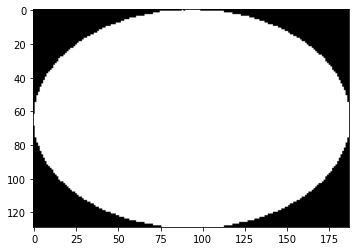

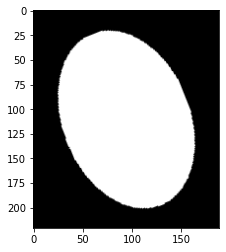

464 464
189 221
167 236


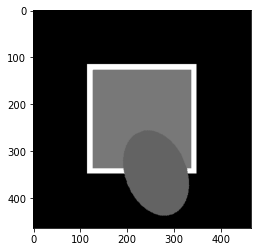

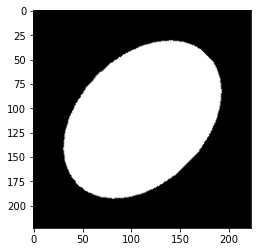

0.3004794120788574
(464, 464)
[202   7]
313 118
0.0
0.025480985641479492


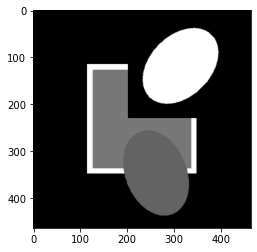

In [179]:
import time
parent_image = cv.imread('../top_view_images/cube_container_01.png')
print(asarray(parent_image).shape)
child_image = cv.imread('../top_view_images/ellipse_rect_cont_01_small_bottom.png')
cur_time = time.time()
parent_image = preprocess_image_sizes(parent_image, child_image)
past_time = time.time() - cur_time
cur_time = time.time()
combined = create_parent_image(parent_image, child_image, -0.126, -0.49, 112, scale=234.4)
past_time = time.time() - cur_time
numpy.unique(combined)

cur_time = time.time()
child_image = cv.imread('../top_view_images/ellipse_container_01_small_bottom.png')
child_image_rot = rotate_image(child_image, 45)
pyplot.imshow(child_image_rot)
pyplot.show()
parent_image = preprocess_image_sizes(combined, child_image_rot)
past_time = time.time() - cur_time
print(past_time)
# pyplot.imshow(child_image)
# pyplot.show()
# pyplot.imshow(combined)
cur_time = time.time()
result = can_sup(combined, child_image_rot)
past_time = time.time() - cur_time
print(past_time)
if result is None: print("not supportable")
combined[result[1]:result[1]+child_image_rot.shape[0], result[0]:result[0]+child_image_rot.shape[1]] = child_image_rot
pyplot.imshow(combined)

In [ ]:
%timeit for _ in range(1000): True

In [92]:
def preprocess_image_sizes(parent_im, child_im):
    #Find the diagonal pixels of the child_im
    (rows, cols, d) = child_im.shape
    diag_pixels = int(math.sqrt(rows ** 2 + cols ** 2))
#     print(rows, cols)
#     print(diag_pixels)

    (rows_p, cols_p, d_p) = parent_im.shape
#     print(rows_p, cols_p)

    #Add pixels as buffer
    diag_pixels = diag_pixels + max(rows, cols) + 50

    if (diag_pixels > rows_p) or (diag_pixels > cols_p):
        #Create a blank image
        super_parent = numpy.zeros((diag_pixels, diag_pixels, d), numpy.uint8)
        (rows_sp, cols_sp, d_sp) = super_parent.shape

        #Add the parent to the center
        r_start = int(rows_sp * 0.5 - rows_p * 0.5)
        c_start = int(cols_sp * 0.5 - cols_p * 0.5)
        
        for r in range(rows_p):
            for c in range(cols_p):
                # Changed from [c, r] to [r, c]
                super_parent[c_start + c, r_start + r] = parent_im[r, c]

#         pyplot.imshow(parent_im)
#         pyplot.show()
#         pyplot.imshow(super_parent)
#         pyplot.show()

        return super_parent
    else:
        return parent_im

(233, 233, 3)


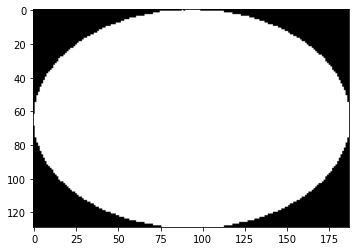

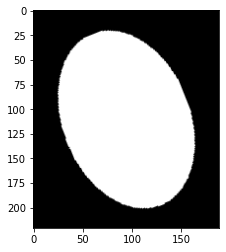

464 464
189 221
167 236


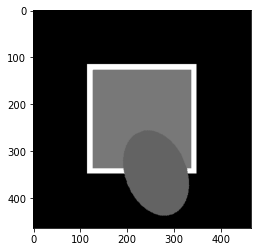

array([  0,  99, 120, 255], dtype=uint8)

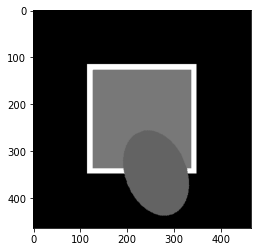

In [132]:
parent_image = cv.imread('../top_view_images/cube_container_01.png')
print(asarray(parent_image).shape)
child_image = cv.imread('../top_view_images/ellipse_rect_cont_01_small_bottom.png')
# rotated_child = rotate_image(child_image, 116.8)
# pyplot.imshow(rotated_child)
parent_image = preprocess_image_sizes(parent_image, child_image)
combined = create_parent_image(parent_image, child_image, -0.126, -0.49, 112, scale=234.4)
pyplot.imshow(combined)
numpy.unique(combined)

In [ ]:
parent_image = cv.imread('../top_view_images/long_cylinder_01_large.png')
child_image = cv.imread('../top_view_images/cube_01_large.png')
rotated_child = rotate_image(child_image, 116.8)
pyplot.imshow(rotated_child)
parent_image = preprocess_image_sizes(parent_image, rotated_child)
combined = create_parent_image(parent_image, rotated_child, -0.66, -0.104, 0)
pyplot.imshow(combined)

In [ ]:
target_image = cv.imread('../top_view_images/cube_01_small.png')
check_support(combined, target_image)

(233, 233, 3)
[120 255]
Object is container
(120, 127, 3)
[  0 120 255]
Object is container


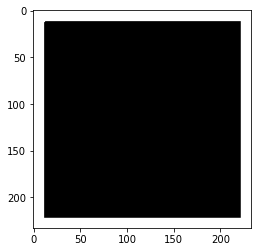

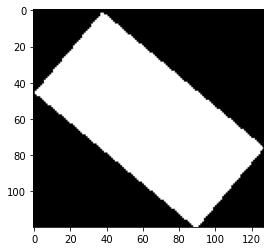

Unique parent_np: [0 1]
Unique child_np: [0 1]
V shape:  (114, 107, 120, 127)
Parent shape:  (233, 233)
Child shape:  (120, 127)
child_np_tile shape:  (114, 107, 120, 127)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [37]:
parent_image = cv.imread('../top_view_images/cube_container_01.png')
child_image = cv.imread('../top_view_images/thin_rectangle_01_small_bottom.png')
child_image = rotate_image(child_image, 140)
# parent_np = image2nptemplate_support(parent_image)
# child_np = image2nptemplate_support(rotate_image(child_image, 140))

check_support(parent_image, child_image)